# GAN simple

GANを簡単に理解して簡単に実装してみる．

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import display

batch_size = 64 # バッチサイズ
nz = 100 # ノイズの次元数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")
device

device(type='mps')

## MNIST

GANで手書き数字を生成する

In [3]:
dataset = MNIST(
    root="datasets/",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True # バッチサイズがずれると面倒くさいので最後は切り捨て
)

sample_x, _ = next(iter(dataloader))
w, h = sample_x.shape[2:]
image_size = w * h # 画像のサイズ
print("batch shape:", sample_x.shape)
print("width:", w)
print("height:", h)
print("image size:", image_size)

batch shape: torch.Size([64, 1, 28, 28])
width: 28
height: 28
image size: 784


## 識別器

*Discriminator*

$28 \times 28 = 784$次元のベクトルを入力し，$0 \sim 1$の確率を出力するNN．確率は入力画像が**偽物**である確率を表す．  
全結合層とReLUで構築する．

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(), # 1x28x28 -> 784
            nn.Linear(image_size, 512), # 全結合層
            nn.ReLU(), # ReLU
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(), # 0~1に
        )

    def forward(self, x):
        y = self.net(x)
        return y

## 生成器

*Generator*

ノイズを入力して$28 \times 28$の画像を出力するNN．各ピクセルの濃淡は$0 \sim 1$の値で表す．1に近いほど白くなる．  
全結合層とReLUとバッチ正規化で構築．バッチ正規化がないと上手くいかない．

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self._linear_block(nz, 128),
            self._linear_block(128, 256),
            self._linear_block(256, 512),
            nn.Linear(512, image_size),
            nn.Sigmoid() # 濃淡を0~1に
        )

    def _linear_block(self, input_size, output_size):
        return nn.Sequential(
            nn.Linear(input_size, output_size), # 全結合層
            nn.BatchNorm1d(output_size), # バッチ正規化
            nn.ReLU() # ReLU
        )

    def forward(self, x):
        y = self.net(x)
        y = y.view(-1, 1, w, h) # 784 -> 1x28x28
        return y

全結合→バッチ正規化→ReLUの流れを`_linear_block()`関数にまとめている．

## 学習

敵対的学習による学習．

In [6]:
# ノイズを生成する関数
def make_noise(batch_size=batch_size):
    return torch.randn(batch_size, nz, device=device)

# 画像を生成して描画する関数
def write(netG, n_rows=1, n_cols=8, size=64):
    z = make_noise(n_rows*n_cols)
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, n_cols)
    img = transforms.functional.to_pil_image(img)
    display(img)

### 識別器
本物と偽物を正しく識別できるように学習する=本物を入れた時は0，偽物を入れた時は1を出力するように学習する．

### 生成器
識別器に0と出力されるような画像=本物に見える画像を生成するように学習する．  
**0に近づきたい = 小さくしたい** と捉えられるので、識別器の出力をそのまま**損失**として扱って逆伝播を行う

<br>

指定したエポック数の学習を行う関数を定義する．

- 引数
    - 生成器
    - 識別器
    - 生成器の活性化関数
    - 識別器の活性化関数
    - エポック数

In [16]:
real_labels = torch.zeros(batch_size, 1).to(device) # 本物を表すラベル(0)
fake_labels = torch.ones(batch_size, 1).to(device) # 偽物を表すラベル(1)
criterion = nn.MSELoss() # 誤差関数


def train(netD, netG, optimD, optimG, n_epochs, write_interval=1):
    # 学習モード
    netD.train()
    netG.train()

    for epoch in range(1, n_epochs+1):
        for x, _ in dataloader: # 本物をバッチサイズ分取り出す
            x = x.to(device)

            # 勾配をリセット
            optimD.zero_grad()
            optimG.zero_grad()

            # 識別器の学習 -----------------------------------------------
            z = make_noise() # ノイズを生成
            fake = netG(z) # ノイズから偽物を生成
            pred_fake = netD(fake) # 偽物を判定
            pred_real = netD(x) # 本物を判定
            loss_fake = (1 - pred_fake).mean() # 偽物の判定に対する誤差
            loss_real = pred_real.mean() # 本物の判定に対する誤差
            # loss_fake = criterion(pred_fake, fake_labels)
            # loss_real = criterion(pred_real, real_labels)
            lossD = loss_fake + loss_real # 二つの誤差の和
            lossD.backward() # 逆伝播
            optimD.step() # パラメータ更新


            # 生成器の学習 -----------------------------------------------
            fake = netG(z) # 偽物を生成
            pred = netD(fake) # 偽物を判定
            lossG = pred.sum() # 和をとる
            lossG.backward() # 逆伝播
            optimG.step() # パラメータ更新

        print(f'{epoch:>3}epoch | lossD: {lossD:.4f}, lossG: {lossG:.4f}')
        if epoch % write_interval == 0:
            write(netG)

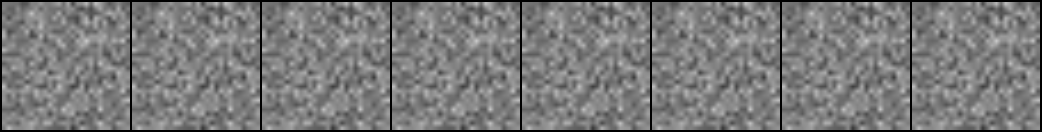

In [17]:
write(Generator().to(device), size=128)

初期状態


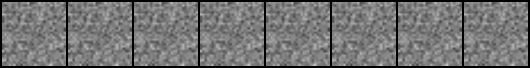

  1epoch | lossD: 0.0005, lossG: 63.9813


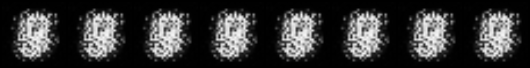

  2epoch | lossD: 0.0000, lossG: 64.0000


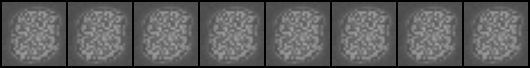

KeyboardInterrupt: 

In [18]:
netD = Discriminator().to(device)
netG = Generator().to(device)
optimD = optim.Adam(netD.parameters(), lr=0.0002)
optimG = optim.Adam(netG.parameters(), lr=0.0002)
n_epochs = 5

print('初期状態')
write(netG)
train(netD, netG, optimD, optimG, n_epochs)

いい感じに成長していそうなので、このまま30回学習させる

  1epoch | lossD: 0.0494, lossG: 63.0668
  2epoch | lossD: 0.1380, lossG: 61.1730
  3epoch | lossD: 0.1404, lossG: 60.5982
  4epoch | lossD: 0.3677, lossG: 57.6976
  5epoch | lossD: 0.2428, lossG: 59.6725


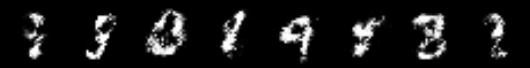

  6epoch | lossD: 0.2732, lossG: 57.9299
  7epoch | lossD: 0.5133, lossG: 56.2022
  8epoch | lossD: 0.7263, lossG: 51.3178
  9epoch | lossD: 0.5627, lossG: 52.2499
 10epoch | lossD: 0.5201, lossG: 51.5321


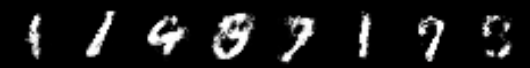

 11epoch | lossD: 0.8288, lossG: 46.5563
 12epoch | lossD: 0.7423, lossG: 49.7364
 13epoch | lossD: 0.6852, lossG: 47.6752
 14epoch | lossD: 0.7878, lossG: 48.4187
 15epoch | lossD: 0.8225, lossG: 49.2403


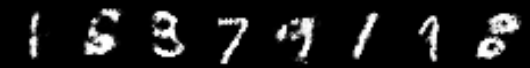

 16epoch | lossD: 0.9254, lossG: 45.1753
 17epoch | lossD: 0.9755, lossG: 43.7134
 18epoch | lossD: 0.7677, lossG: 45.7210
 19epoch | lossD: 1.0541, lossG: 43.7291
 20epoch | lossD: 0.8916, lossG: 43.9847


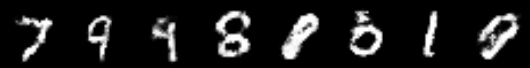

In [21]:
train(netD, netG, optimD, optimG, 20, write_interval=5)

学習完了。結果はこうなった↑。

もう少したくさん見てみる

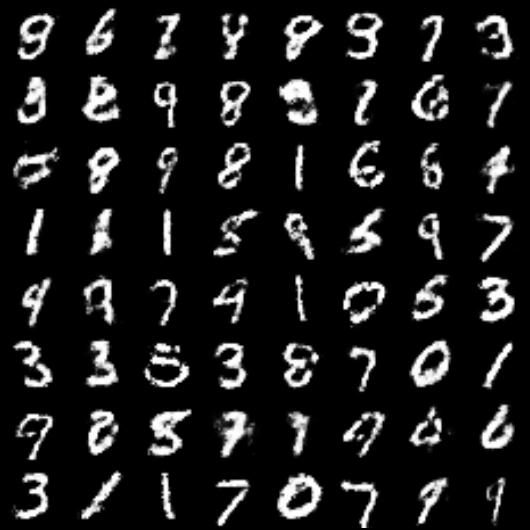

In [22]:
write(netG, 8)

上手く学習できた